In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad, simps
from scipy.optimize import curve_fit
from scipy.special import erf
import sympy as sp
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches

In [2]:
# ============================================================================
# TELESCOPE SELECTION
# ============================================================================
# Choose telescope: "parkes", "fast", "meerkat_incoherent", or "meerkat_coherent"
# TELESCOPE = "parkes"
# TELESCOPE = "fast"
# TELESCOPE = "meerkat_incoherent"
TELESCOPE = "meerkat_coherent"
# ============================================================================

# Telescope parameters dictionary
TELESCOPE_PARAMS = {
    "parkes": {
        "D": 64,
        "eta": 0.6,
        "Trec": 25,
        "Tsky": 3,
        "BW": 800e6,
        "nu_min": 1.0e9,
        "nu_max": 1.8e9,
        "n_chan": 16,
        "n_dishes": 1,  # Single dish
    },
    "fast": {
        "D": 300, # physical size
        "eta": 0.6,
        "Trec": 24,
        "Tsky": 3,
        "BW": 500e6,
        "nu_min": 1.0e9,
        "nu_max": 1.5e9,
        "n_chan": 16,
        "n_dishes": 1,  # Single dish
    },
    "meerkat_incoherent": {
        "D": 13.5,
        "eta": 0.70, 
        "Trec": 20,   
        "Tsky": 3,
        "BW": 856e6,
        "nu_min": 856e6,
        "nu_max": 1.711e9,
        "n_chan": 16,
        "n_dishes": 64,
        "mode": "incoherent",
        "description": "MeerKAT array - incoherent beam (power addition)",
    },
    "meerkat_coherent": {
        "D": 13.5,
        "eta": 0.70,  
        "Trec": 20,   
        "Tsky": 3,
        "BW": 856e6,
        "nu_min": 856e6,
        "nu_max": 1.711e9,
        "n_chan": 16,
        "n_dishes": 64,
        "mode": "coherent",
        "description": "MeerKAT array - coherent beam (phase alignment)",
    },
}


In [3]:

# Load selected telescope parameters
if TELESCOPE.lower() not in TELESCOPE_PARAMS:
    raise ValueError(f"Telescope must be one of: {list(TELESCOPE_PARAMS.keys())}")

params = TELESCOPE_PARAMS[TELESCOPE.lower()]

# Physical constants
k = 1.38e-23  # Boltzmann constant
c = 3.0e8     # Speed of light

# Extract parameters
D = params["D"]
eta = params["eta"]
n_dishes = params.get("n_dishes", 1)
mode = params.get("mode", "single")


# Calculate array gain factor based on beamforming mode
if mode == "coherent":
    # Coherent beamforming: ALL dishes phase-aligned → constructive interference
    # Sensitivity scales as N_dishes (not sqrt)
    # Signal adds coherently: S_total ∝ N * S_single
    array_gain_factor = n_dishes
    gain_description = f"Coherent ({n_dishes}× - phase aligned)"
    
elif mode == "incoherent":
    # Incoherent beamforming: power addition with coherence loss
    # Signals add incoherently (random phases)
    # S_total ∝ sqrt(N) * S_single (noise dominates)
    # Typical coherence loss ~15%
    coherence_loss = 0.85
    array_gain_factor = np.sqrt(n_dishes) * coherence_loss
    gain_description = f"Incoherent (√{n_dishes} × {coherence_loss} = {array_gain_factor:.2f}×)"
    
else:
    # Single dish (Parkes, FAST)
    array_gain_factor = 1.0
    gain_description = "Single dish"

# Apply array gain to system sensitivity
G0 = np.pi * D*D/4 * eta/2.0/k*1e-26 * array_gain_factor
nu0 = 1.4e9  # reference frequency in Hz
Np = 2
Trec = params["Trec"]
Tsky = params["Tsky"]
BW = params["BW"]
n_chan = params["n_chan"]
BW_chan = BW / n_chan
nu_min = params["nu_min"]
nu_max = params["nu_max"]


# FRB Parameters
S0_mean = 1  # Jy
S0_sigma = 0.5
alpha_mean = -2.0  # Gaussian center at -2
alpha_sigma = 0.5  # Standard deviation of spectral index
theta_min = 0.0
theta_max = theta_max = 2*1.22*c/D/nu_min #   # Angular offset (rad) from 0 to 0.005
t = 0.001

In [4]:
np.random.seed(42)

n_frb = 10000
nu_array = np.linspace(nu_min, nu_max, n_chan)

# FRB properties
frb_S0 = []  # Flux density at reference frequency (log-normal)
frb_alpha_intrinsic = []  # Intrinsic spectral index (Gaussian centered at -2)
frb_theta = []  # Angular offset (Gaussian distribution)
frb_alpha_inferred = []  # Observed spectral index (fitted)
frb_snr = []  # SNR at reference frequency
frb_detected = []  # Detection flag
frb_snr_coherent = []



In [5]:
def gaussian_beam_gain(nu, G0, theta, D, c):
    """
    Gaussian beam gain with frequency dependence
    G(ν) = G₀ × exp[−θ²ν²D²×2.355²/(2×1.22²×c²)]

    Returns:
    Gain (K/Jy)
    """
    # Exponent coefficient
    coeff = (theta**2 * D**2 * 2.355**2) / (2 * 1.22**2 * c**2)
    return G0 * np.exp(-coeff * nu**2)

def SNR(S,t,G,BW,Np,Trec,Tsky):
    return(S*G*np.sqrt(BW*t*Np)/(Trec+Tsky))




Instrinsic spectral index distribution: Gaussian


In [6]:
# Generate FRBs
# FRB properties
frb_S0 = []  # Flux density at reference frequency (log-normal)
frb_alpha_intrinsic = []  # Intrinsic spectral index (Gaussian centered at -2)
frb_theta = []  # Angular offset (Gaussian distribution)
frb_alpha_inferred = []  # Observed spectral index (fitted)
frb_snr = []  # SNR at reference frequency
frb_detected = []  # Detection flag
frb_snr_coherent = []
for i in range(n_frb):
    
    # S0: Log-normal distribution
    mu = np.log(S0_mean) - S0_sigma**2 / 2.0
    S0_frb = np.random.lognormal(mean=mu, sigma=S0_sigma)
    frb_S0.append(S0_frb)
    
    # Intrinsic spectral index: Uniform between 0 and -5
    alpha_intrinsic = np.random.normal(loc=alpha_mean, scale=alpha_sigma)
    frb_alpha_intrinsic.append(alpha_intrinsic)
    
    # Angular offset: Uniform distribution between 0 and theta_max
    theta_frb = theta_max * np.sqrt(np.random.random())
    theta_frb = np.abs(theta_frb)  # Ensure positive
    frb_theta.append(theta_frb)
    
    # STAGE 1: Quick check at reference frequency with on-axis beam
    S_nu_low = S0_frb * (nu_min / nu0)**alpha_intrinsic
    G_max = gaussian_beam_gain(nu0, G0, 0, D, c)
    snr_max = SNR(S_nu_low, t, G_max, BW, Np, Trec, Tsky)
    
    # Skip FRB if initial SNR check fails
    if snr_max < 10:
        frb_snr.append(np.nan)
        frb_snr_coherent.append(np.nan)
        frb_detected.append(False)
        frb_alpha_inferred.append(np.nan)
        continue
    
    # STAGE 2: Calculate SNR spectrum across frequency band (vectorized)
    S_nu = S0_frb * (nu_array / nu0)**alpha_intrinsic
    G_nu = gaussian_beam_gain(nu_array, G0, theta_frb, D, c)
    snr_spectrum = SNR(S_nu, t, G_nu, BW_chan, Np, Trec, Tsky)
    
    # SNR at reference frequency
    S_nu0 = S0_frb
    G_nu0 = gaussian_beam_gain(nu0, G0, theta_frb, D, c)
    snr_nu0 = SNR(S_nu0, t, G_nu0, BW_chan, Np, Trec, Tsky)
    frb_snr.append(snr_nu0)
    
    # Detection criterion: coherent SNR > 10
    snr_coherent = np.sqrt(np.sum(snr_spectrum**2) / len(snr_spectrum))
    frb_snr_coherent.append(snr_coherent)
    is_detected = snr_coherent > 10
    frb_detected.append(is_detected)
    
    # STAGE 3: Only fit spectral index if detected
    if is_detected:
        try:
            def power_law(nu, a, b):
                return a * (nu ** b)
            
            popt, _ = curve_fit(power_law, nu_array, snr_spectrum, 
                               p0=[1e-20, 2], maxfev=5000)
            a_fit, alpha_observed = popt
            frb_alpha_inferred.append(alpha_observed)
        except:
            frb_alpha_inferred.append(np.nan)
    else:
        frb_alpha_inferred.append(np.nan)

# Convert to arrays
frb_S0 = np.array(frb_S0)
frb_alpha_intrinsic = np.array(frb_alpha_intrinsic)
frb_theta = np.array(frb_theta)
frb_alpha_inferred = np.array(frb_alpha_inferred)
frb_snr = np.array(frb_snr)
frb_snr_coherent = np.array(frb_snr_coherent)
frb_detected = np.array(frb_detected)

n_detected = np.sum(frb_detected)
detection_rate = n_detected / n_frb * 100

frb_detected_flat = frb_detected

<ipython-input-6-b171d64c9206>:60: RuntimeWarning: overflow encountered in power
  return a * (nu ** b)


-0.40426179988864464


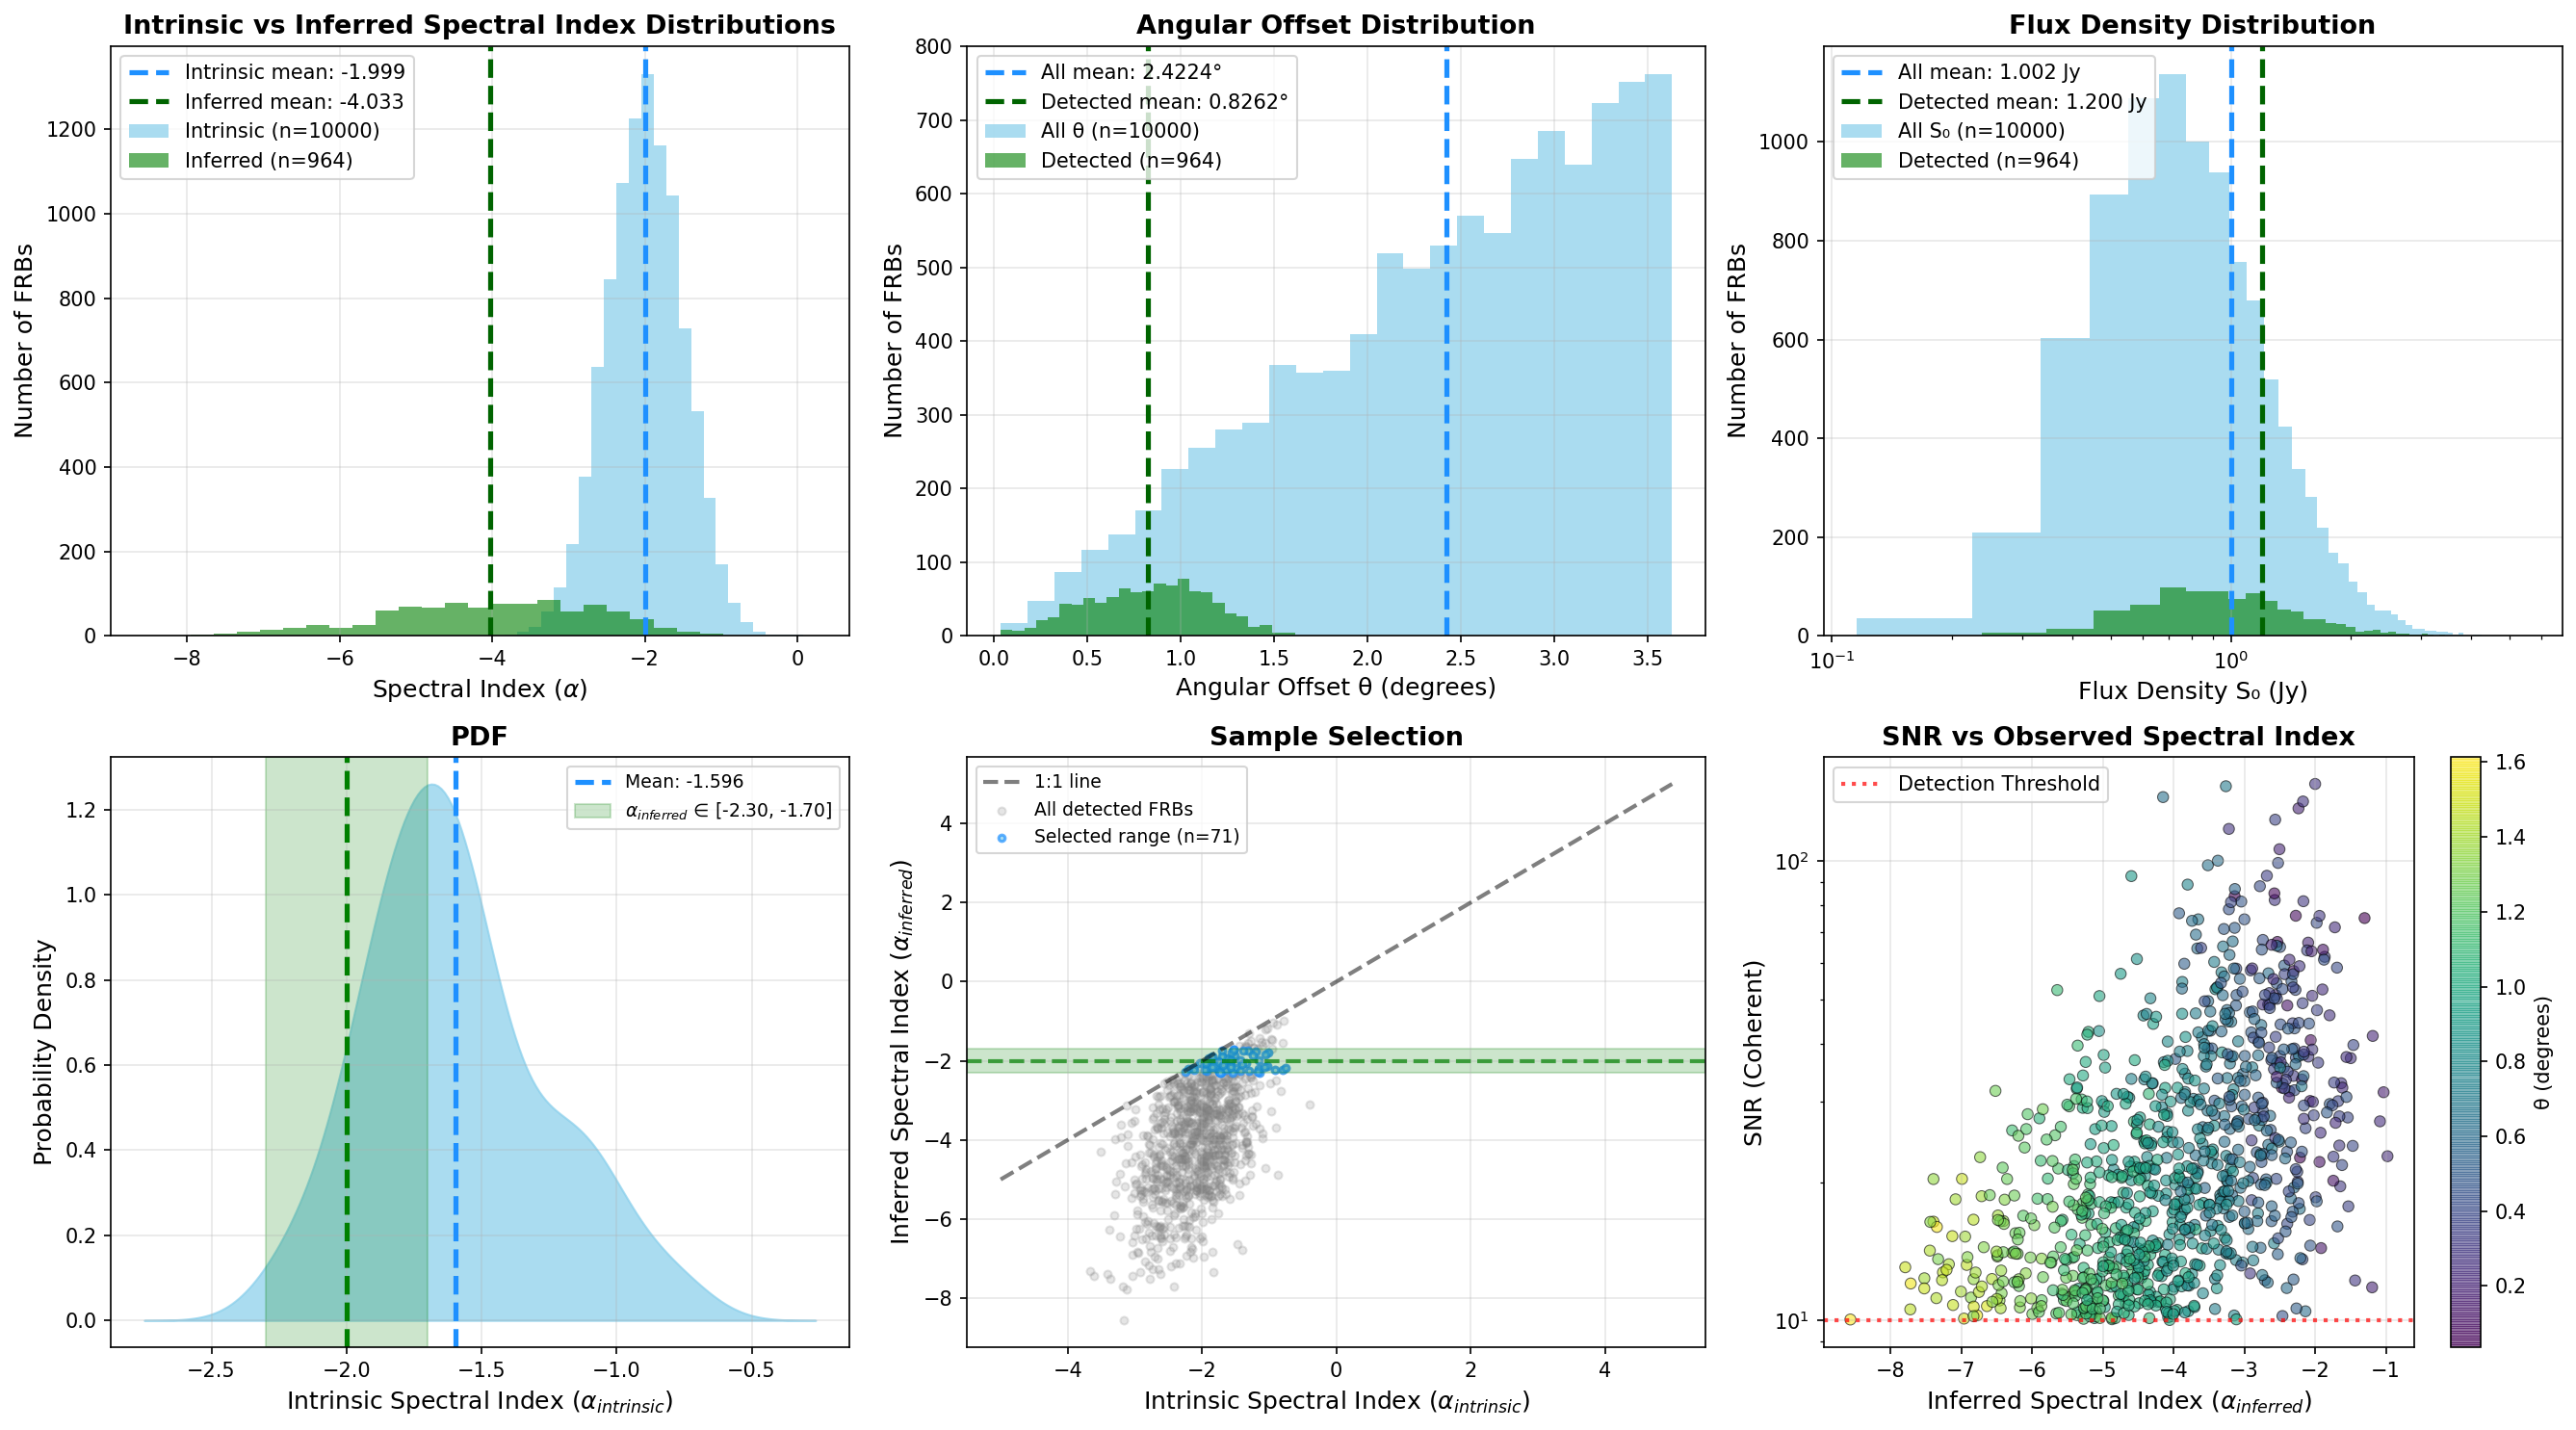

In [7]:
# Plot histograms and comparisons
fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi=150)

# Plot 1  Combined: Spectral Index Distributions
ax = axes[0, 0]
# Plot intrinsic spectral index (skyblue)
ax.hist(frb_alpha_intrinsic, bins=25, alpha=0.7, color='skyblue', edgecolor='none', 
        label=f'Intrinsic (n={len(frb_alpha_intrinsic)})')
ax.axvline(np.mean(frb_alpha_intrinsic), color='dodgerblue', linestyle='--', linewidth=2.5, 
           label=f'Intrinsic mean: {np.mean(frb_alpha_intrinsic):.3f}')

# Overlay inferred spectral index (green)
alpha_inferred_detected = frb_alpha_inferred[frb_detected & ~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_inferred_detected, bins=25, alpha=0.6, color='green', edgecolor='none', 
        label=f'Inferred (n={len(alpha_inferred_detected)})')
ax.axvline(np.mean(alpha_inferred_detected), color='darkgreen', linestyle='--', linewidth=2.5, 
           label=f'Inferred mean: {np.mean(alpha_inferred_detected):.3f}')

ax.set_xlabel('Spectral Index ($\\alpha$)', fontsize=12)
ax.set_ylabel('Number of FRBs', fontsize=12)
ax.set_title('Intrinsic vs Inferred Spectral Index Distributions', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Flux Density 
ax = axes[0, 2]
# Plot flux density distribution (skyblue)
ax.hist(frb_S0, bins=50, alpha=0.7, color='skyblue', edgecolor='none', 
        label=f'All S₀ (n={len(frb_S0)})')
ax.axvline(np.mean(frb_S0), color='dodgerblue', linestyle='--', linewidth=2.5, 
           label=f'All mean: {np.mean(frb_S0):.3f} Jy')

# Overlay detected flux density (green)
S0_detected = frb_S0[frb_detected]
ax.hist(S0_detected, bins=50, alpha=0.6, color='green', edgecolor='none', 
        label=f'Detected (n={len(S0_detected)})')
ax.axvline(np.mean(S0_detected), color='darkgreen', linestyle='--', linewidth=2.5, 
           label=f'Detected mean: {np.mean(S0_detected):.3f} Jy')

ax.set_xlabel('Flux Density S₀ (Jy)', fontsize=12)
ax.set_ylabel('Number of FRBs', fontsize=12)
ax.set_title('Flux Density Distribution', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Angular offset distribution 
ax = axes[0, 1]
ax.hist(np.degrees(frb_theta), bins=25, alpha=0.7, color='skyblue', edgecolor='none', 
        label=f'All θ (n={len(frb_theta)})')
ax.axvline(np.degrees(np.mean(frb_theta)), color='dodgerblue', linestyle='--', linewidth=2.5, 
           label=f'All mean: {np.degrees(np.mean(frb_theta)):.4f}°')

# Overlay detected angular offsets (green)
theta_detected = np.degrees(frb_theta[frb_detected])
ax.hist(theta_detected, bins=25, alpha=0.6, color='green', edgecolor='none', 
        label=f'Detected (n={len(theta_detected)})')
ax.axvline(np.degrees(np.mean(frb_theta[frb_detected])), color='darkgreen', linestyle='--', linewidth=2.5, 
           label=f'Detected mean: {np.degrees(np.mean(frb_theta[frb_detected])):.4f}°')

ax.set_xlabel('Angular Offset θ (degrees)', fontsize=12)
ax.set_ylabel('Number of FRBs', fontsize=12)
ax.set_title('Angular Offset Distribution', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Conditional PDF
ax = axes[1, 0]
detected_mask = frb_detected & ~np.isnan(frb_alpha_inferred)
alpha_intrinsic_det = frb_alpha_intrinsic[detected_mask]
alpha_inferred_det = frb_alpha_inferred[detected_mask]

alpha_inferred_target = -2
delta_alpha = 0.3
mask_range = (alpha_inferred_det >= alpha_inferred_target - delta_alpha) & \
             (alpha_inferred_det <= alpha_inferred_target + delta_alpha)

intrinsic_conditional = alpha_intrinsic_det[mask_range]

if len(intrinsic_conditional) > 2:
    kde_conditional = gaussian_kde(intrinsic_conditional)
    alpha_range = np.linspace(intrinsic_conditional.min() - 0.5, 
                               intrinsic_conditional.max() + 0.5, 200)
    pdf_conditional = kde_conditional(alpha_range)
    
    ax.fill_between(alpha_range, pdf_conditional, alpha=0.7, color='skyblue')
    ax.plot(alpha_range, pdf_conditional, 'dodgerblue', linewidth= 0)
    ax.axvline(np.mean(intrinsic_conditional), color='dodgerblue', linestyle='--', linewidth=2.5, 
               label=f'Mean: {np.mean(intrinsic_conditional):.3f}')
    print(alpha_inferred_target-np.mean(intrinsic_conditional))
    ax.axvspan(alpha_inferred_target - delta_alpha, alpha_inferred_target + delta_alpha, 
               alpha=0.2, color='green', label=f'$\\alpha_{{inferred}}$ ∈ [{alpha_inferred_target - delta_alpha:.2f}, {alpha_inferred_target + delta_alpha:.2f}]')
    ax.axvline(alpha_inferred_target, color='green', linestyle='--', linewidth=2.5)
    
    ax.set_xlabel('Intrinsic Spectral Index ($\\alpha_{{intrinsic}}$)', fontsize=12)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.set_title(f'PDF', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Plot 5: Scatter with highlight
ax = axes[1, 1]
ax.scatter(alpha_intrinsic_det, alpha_inferred_det, alpha=0.2, s=15, 
          color='gray', label='All detected FRBs')
ax.scatter(intrinsic_conditional, alpha_inferred_det[mask_range], alpha=0.7, s=10, 
          color='skyblue', edgecolor='dodgerblue', linewidth=1.5, 
          label=f'Selected range (n={np.sum(mask_range)})')
ax.axhspan(alpha_inferred_target - delta_alpha, alpha_inferred_target + delta_alpha, 
          alpha=0.2, color='green')
ax.axhline(alpha_inferred_target, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax.plot([-5, 5], [-5, 5], 'k--', linewidth=2, label='1:1 line', alpha=0.5)

ax.set_xlabel('Intrinsic Spectral Index ($\\alpha_{{intrinsic}}$)', fontsize=12)
ax.set_ylabel('Inferred Spectral Index ($\\alpha_{{inferred}}$)', fontsize=12)
ax.set_title('Sample Selection', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 6: SNR vs inferred spectral index (ONLY DETECTED FRBs)
ax = axes[1, 2]
valid_mask = frb_detected & ~np.isnan(frb_alpha_inferred) & ~np.isnan(frb_snr_coherent)
scatter = ax.scatter(frb_alpha_inferred[valid_mask], frb_snr_coherent[valid_mask], 
                     c=np.degrees(frb_theta[valid_mask]), 
                     cmap='viridis', alpha=0.6, s=30, edgecolor='black', linewidth=0.5)
ax.axhline(y=10, color='red', linestyle=':', linewidth=2, label='Detection Threshold', alpha=0.7)
ax.set_xlabel('Inferred Spectral Index ($\\alpha_{{inferred}}$)', fontsize=12)
ax.set_ylabel('SNR (Coherent)', fontsize=12)
ax.set_title('SNR vs Observed Spectral Index', fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('θ (degrees)', fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

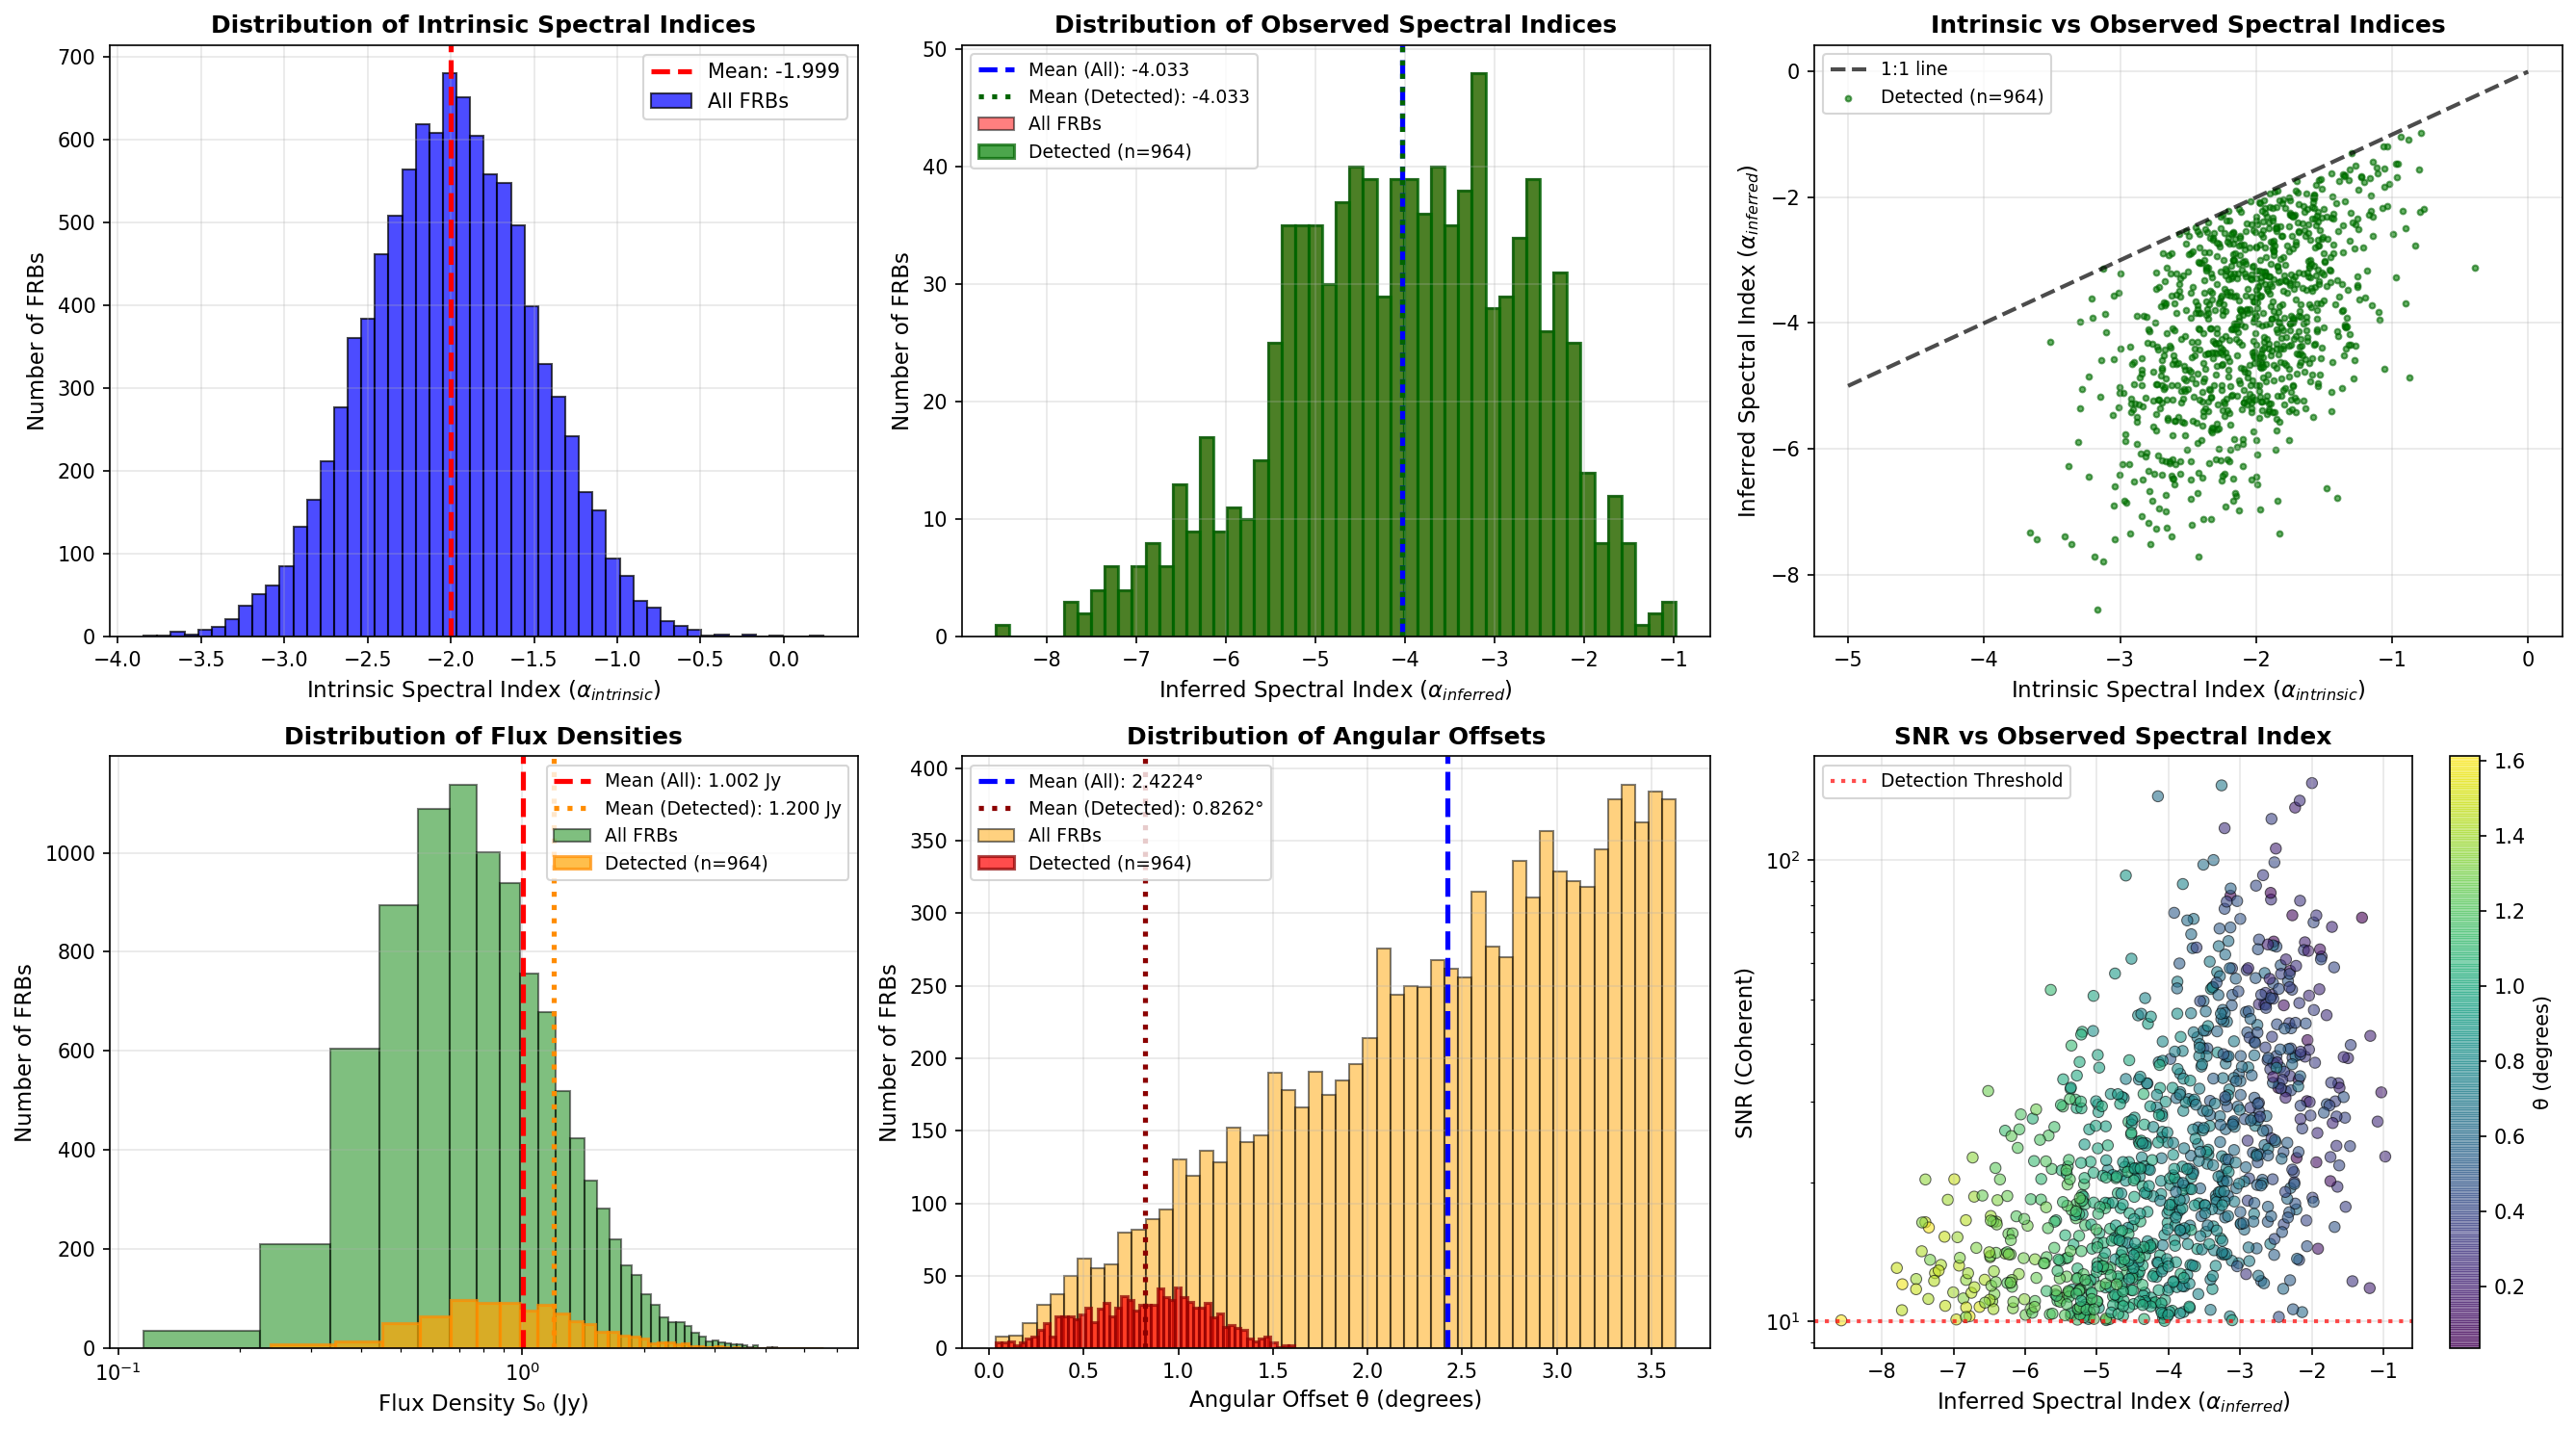

In [8]:
# Plot histograms and comparisons
fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi=150)

# Plot 1: Intrinsic spectral index distribution
ax = axes[0, 0]
ax.hist(frb_alpha_intrinsic, bins=50, alpha=0.7, color='blue', edgecolor='black', label='All FRBs')
ax.axvline(np.mean(frb_alpha_intrinsic), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {np.mean(frb_alpha_intrinsic):.3f}')
ax.set_xlabel('Intrinsic Spectral Index ($\\alpha_{{intrinsic}}$)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Intrinsic Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Inferred spectral index distribution (with detected overlay)
ax = axes[0, 1]
alpha_inferred_valid = frb_alpha_inferred[~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_inferred_valid, bins=50, alpha=0.5, color='red', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
alpha_inferred_detected = frb_alpha_inferred[frb_detected & ~np.isnan(frb_alpha_inferred)]
ax.hist(alpha_inferred_detected, bins=50, alpha=0.7, color='green', edgecolor='darkgreen', 
        linewidth=1.5, label=f'Detected (n={len(alpha_inferred_detected)})')

ax.axvline(np.mean(alpha_inferred_valid), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.mean(alpha_inferred_valid):.3f}')
ax.axvline(np.mean(alpha_inferred_detected), color='darkgreen', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.mean(alpha_inferred_detected):.3f}')
ax.set_xlabel('Inferred Spectral Index ($\\alpha_{{inferred}}$)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Observed Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Intrinsic vs Inferred (ONLY DETECTED FRBs)
ax = axes[0, 2]
# Only plot detected FRBs with valid alpha_inferred
detected_mask = frb_detected & ~np.isnan(frb_alpha_inferred)
ax.scatter(frb_alpha_intrinsic[detected_mask], frb_alpha_inferred[detected_mask], 
           alpha=0.6, s=30, color='green', marker='.', edgecolor='darkgreen', linewidth=1,
           label=f'Detected (n={np.sum(detected_mask)})')

ax.plot([-5, 0], [-5, 0], 'k--', linewidth=2, label='1:1 line', alpha=0.7)
ax.set_xlabel('Intrinsic Spectral Index ($\\alpha_{{intrinsic}}$)', fontsize=11)
ax.set_ylabel('Inferred Spectral Index ($\\alpha_{{inferred}}$)', fontsize=11)
ax.set_title('Intrinsic vs Observed Spectral Indices', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: S0 distribution (with detected overlay)
ax = axes[1, 0]
ax.hist(frb_S0, bins=50, alpha=0.5, color='green', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
S0_detected = frb_S0[frb_detected]
ax.hist(S0_detected, bins=50, alpha=0.7, color='orange', edgecolor='darkorange', 
        linewidth=1.5, label=f'Detected (n={len(S0_detected)})')

ax.axvline(np.mean(frb_S0), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.mean(frb_S0):.3f} Jy')
ax.axvline(np.mean(S0_detected), color='darkorange', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.mean(S0_detected):.3f} Jy')
ax.set_xlabel('Flux Density S₀ (Jy)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Flux Densities', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 5: Angular offset distribution (with detected overlay)
ax = axes[1, 1]
ax.hist(np.degrees(frb_theta), bins=50, alpha=0.5, color='orange', edgecolor='black', label='All FRBs')

# Overlay histogram of detected FRBs
theta_detected = np.degrees(frb_theta[frb_detected])
ax.hist(theta_detected, bins=50, alpha=0.7, color='red', edgecolor='darkred', 
        linewidth=1.5, label=f'Detected (n={len(theta_detected)})')

ax.axvline(np.degrees(np.mean(frb_theta)), color='blue', linestyle='--', linewidth=2.5, 
           label=f'Mean (All): {np.degrees(np.mean(frb_theta)):.4f}°')
ax.axvline(np.degrees(np.mean(frb_theta[frb_detected])), color='darkred', linestyle=':', linewidth=2.5, 
           label=f'Mean (Detected): {np.degrees(np.mean(frb_theta[frb_detected])):.4f}°')
ax.set_xlabel('Angular Offset θ (degrees)', fontsize=11)
ax.set_ylabel('Number of FRBs', fontsize=11)
ax.set_title('Distribution of Angular Offsets', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 6: SNR vs inferred spectral index (ONLY DETECTED FRBs)
ax = axes[1, 2]
# Only plot detected FRBs with valid data
valid_mask = frb_detected & ~np.isnan(frb_alpha_inferred) & ~np.isnan(frb_snr_coherent)
scatter = ax.scatter(frb_alpha_inferred[valid_mask], frb_snr_coherent[valid_mask], 
                     c=np.degrees(frb_theta[valid_mask]), 
                     cmap='viridis', alpha=0.6, s=30, edgecolor='black', linewidth=0.5)
ax.axhline(y=10, color='red', linestyle=':', linewidth=2, label='Detection Threshold', alpha=0.7)
ax.set_xlabel('Inferred Spectral Index ($\\alpha_{{inferred}}$)', fontsize=11)
ax.set_ylabel('SNR (Coherent)', fontsize=11)
ax.set_title('SNR vs Observed Spectral Index', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('θ (degrees)', fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()


Number of FRBs in range [-2.80, -2.20]: 130
Mean intrinsic α: -1.822 ± 0.391
Mean inferred α: -2.508 ± 0.174


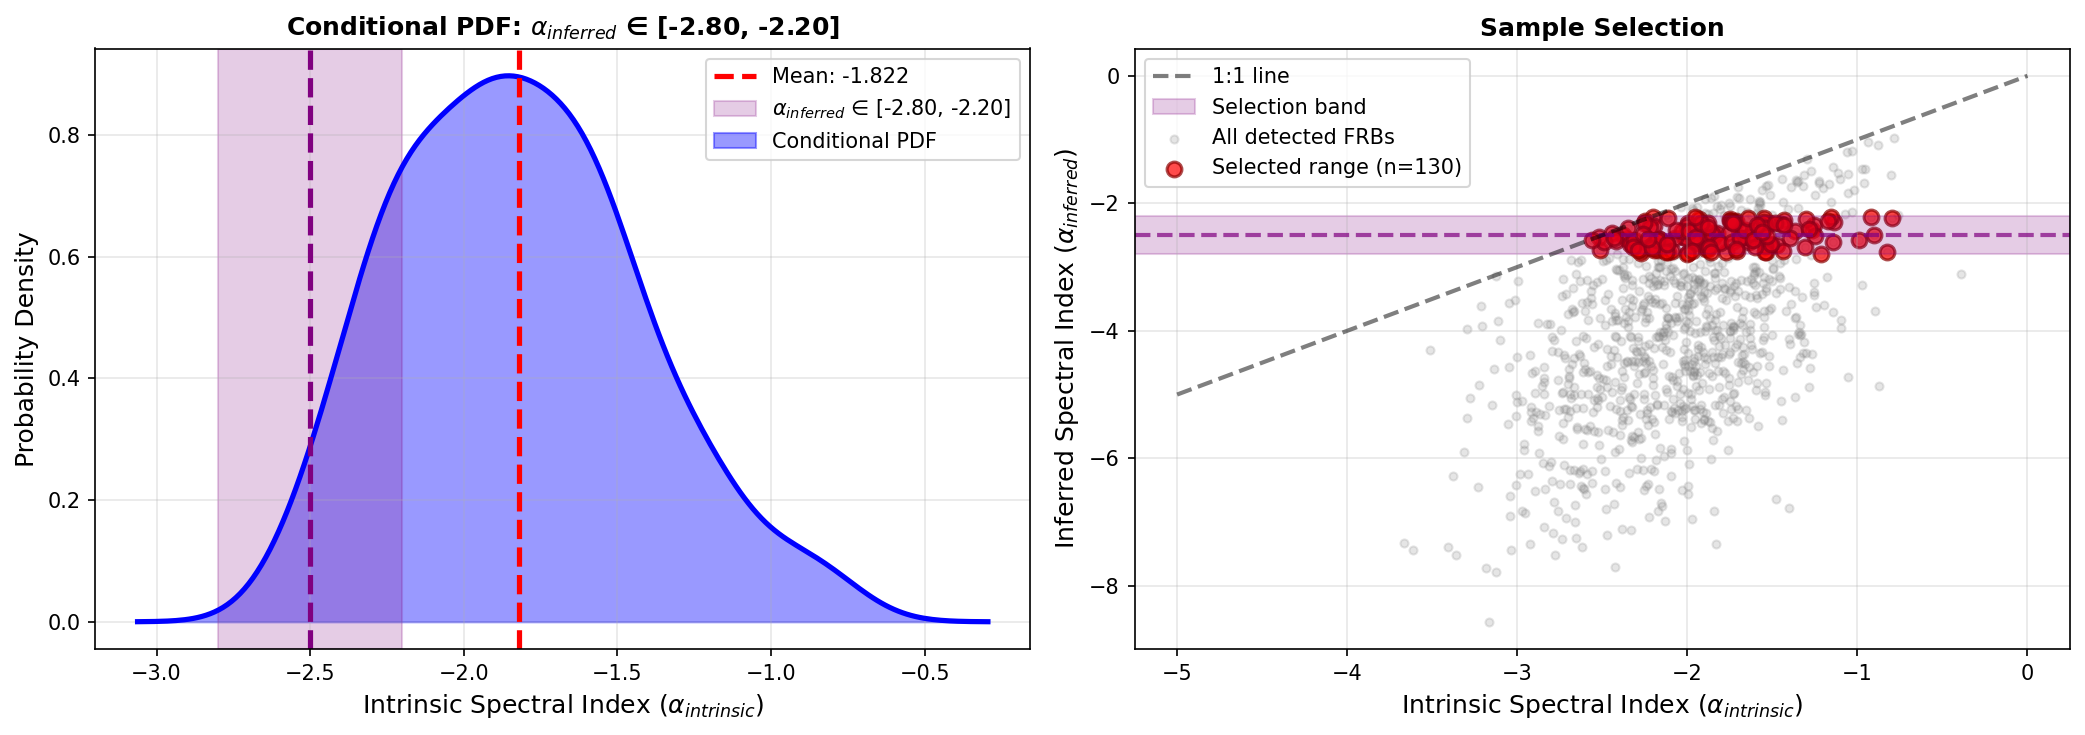

In [9]:
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches


# Get detected FRBs data
detected_mask = frb_detected & ~np.isnan(frb_alpha_inferred) # e.g., boolean array: frb_detected = [True, False, True, False, ...]
alpha_intrinsic_det = frb_alpha_intrinsic[detected_mask]
alpha_inferred_det = frb_alpha_inferred[detected_mask]

# Define inferred spectral index range of interest
alpha_inferred_target = -2.5  # Target inferred spectral index
delta_alpha = 0.3  # Error range (±0.3)

# Filter data within the inferred spectral index range
mask_range = (alpha_inferred_det >= alpha_inferred_target - delta_alpha) & \
             (alpha_inferred_det <= alpha_inferred_target + delta_alpha)

intrinsic_conditional = alpha_intrinsic_det[mask_range] 
inferred_conditional = alpha_inferred_det[mask_range] # [1.51, 1.5,.....]

print(f"Number of FRBs in range [{alpha_inferred_target - delta_alpha:.2f}, {alpha_inferred_target + delta_alpha:.2f}]: {np.sum(mask_range)}")
print(f"Mean intrinsic α: {np.mean(intrinsic_conditional):.3f} ± {np.std(intrinsic_conditional):.3f}")
print(f"Mean inferred α: {np.mean(inferred_conditional):.3f} ± {np.std(inferred_conditional):.3f}")

# Create conditional PDF plot
fig, axes_cond = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

# Left plot: Conditional PDF
ax = axes_cond[0]
if len(intrinsic_conditional) > 2:
    # Create KDE for conditional distribution
    kde_conditional = gaussian_kde(intrinsic_conditional)
    alpha_range = np.linspace(intrinsic_conditional.min() - 0.5, 
                               intrinsic_conditional.max() + 0.5, 200)
    pdf_conditional = kde_conditional(alpha_range)
    
    # Plot PDF
    ax.fill_between(alpha_range, pdf_conditional, alpha=0.4, color='blue', label='Conditional PDF')
    ax.plot(alpha_range, pdf_conditional, 'b-', linewidth=2.5)
    
    # Add statistics - MEAN ONLY
    ax.axvline(np.mean(intrinsic_conditional), color='red', linestyle='--', linewidth=2.5, 
               label=f'Mean: {np.mean(intrinsic_conditional):.3f}')
    
    # Add shaded region for inferred spectral index with error range
    ax.axvspan(alpha_inferred_target - delta_alpha, alpha_inferred_target + delta_alpha, 
               alpha=0.2, color='purple', label=f'$\\alpha_{{inferred}}$ ∈ [{alpha_inferred_target - delta_alpha:.2f}, {alpha_inferred_target + delta_alpha:.2f}]')
    ax.axvline(alpha_inferred_target, color='purple', linestyle='--', linewidth=2.5)
    
    ax.set_xlabel('Intrinsic Spectral Index ($\\alpha_{{intrinsic}}$)', fontsize=12)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.set_title(f'Conditional PDF: $\\alpha_{{inferred}}$ ∈ [{alpha_inferred_target - delta_alpha:.2f}, {alpha_inferred_target + delta_alpha:.2f}]', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Insufficient data in range', ha='center', va='center', 
            transform=ax.transAxes, fontsize=12)
    
# Right plot: Scatter with highlight
ax = axes_cond[1]
# Plot all detected FRBs
ax.scatter(alpha_intrinsic_det, alpha_inferred_det, alpha=0.2, s=15, 
          color='gray', label='All detected FRBs')

# Highlight FRBs in the selected range
ax.scatter(intrinsic_conditional, inferred_conditional, alpha=0.7, s=50, 
          color='red', edgecolor='darkred', linewidth=1.5, 
          label=f'Selected range (n={np.sum(mask_range)})')

# Add selection band
ax.axhspan(alpha_inferred_target - delta_alpha, alpha_inferred_target + delta_alpha, 
          alpha=0.2, color='purple', label='Selection band')
ax.axhline(alpha_inferred_target, color='purple', linestyle='--', linewidth=2, alpha=0.7)

# 1:1 line
ax.plot([-5, 0], [-5, 0], 'k--', linewidth=2, label='1:1 line', alpha=0.5)

ax.set_xlabel('Intrinsic Spectral Index ($\\alpha_{{intrinsic}}$)', fontsize=12)
ax.set_ylabel('Inferred Spectral Index ($\\alpha_{{inferred}}$)', fontsize=12)
ax.set_title('Sample Selection', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()